In [1]:
!nvidia-smi
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install einops sentencepiece wandb tqdm matplotlib pillow opencv-python transformers datasets

Sun Nov 30 02:48:05 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-80GB          Off |   00000000:00:05.0 Off |                    0 |
| N/A   31C    P0             55W /  400W |       0MiB /  81920MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [2]:
# 1️⃣ Install KaggleHub (already done, but safe to rerun)
!pip install -q kagglehub[pandas-datasets]

# 2️⃣ Import
import kagglehub

# 3️⃣ Download the dataset
dataset_path = kagglehub.dataset_download("mssjss/fastmathxassumption-2025-handwritten-math-to-latex")

print("✅ Dataset downloaded to:", dataset_path)

# 4️⃣ List contents
import os
print(os.listdir(dataset_path))

Using Colab cache for faster access to the 'fastmathxassumption-2025-handwritten-math-to-latex' dataset.
✅ Dataset downloaded to: /kaggle/input/fastmathxassumption-2025-handwritten-math-to-latex
['latex_equation_groundtruth.csv', 'paper']


In [3]:
!pip install -q kagglehub torch torchvision torchaudio transformers einops tqdm matplotlib pillow pandas

import os, random, torch, pandas as pd, numpy as np
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')
print("✅ Google Drive mounted successfully!")

Mounted at /content/drive
✅ Google Drive mounted successfully!


In [4]:
# ============================================================
# CB4 — Load & Prepare the Dataset
# ============================================================
import os, re
import pandas as pd

# 1️⃣ Locate the CSV file
csv_path = os.path.join(dataset_path, "latex_equation_groundtruth.csv")
df = pd.read_csv(csv_path)
print("✅ CSV Loaded:", csv_path)
print("📋 Raw Columns:", df.columns.tolist())
print(df.head())

# 2️⃣ Drop rows with missing equation or image path
df = df.dropna(subset=["equation", "image_path"]).reset_index(drop=True)
print("✅ After dropna, rows:", len(df))

# 3️⃣ Standardize column names
df = df.rename(columns={"equation": "latex", "image_path": "filename"})
print("✅ Columns standardized:", df.columns.tolist())

# 4️⃣ Set image root path (inside /paper folder)
image_root = os.path.join(dataset_path, "paper")
print("📂 Image root:", image_root)

# 5️⃣ Fix filenames to be full paths under image_root
def fix_path(p):
    # remove any leading /kaggle/input/... if present
    p = re.sub(r"^/kaggle/input/[^/]+/", "", str(p))
    return os.path.join(image_root, p)

df["filename"] = df["filename"].apply(fix_path)

print("🔍 Sample fixed paths:")
print(df["filename"].head(3))


✅ CSV Loaded: /kaggle/input/fastmathxassumption-2025-handwritten-math-to-latex/latex_equation_groundtruth.csv
📋 Raw Columns: ['arena', 'question_number', 'digits', 'target', 'level', 'equation', 'image_path']
    arena  question_number  digits  target   level  \
0  arena1                1    7598      36  Level2   
1  arena1                1    7598      36  Level2   
2  arena1                1    7598      36  Level2   
3  arena1                1    7598      36  Level2   
4  arena1                1    7598      36  Level2   

                                           equation  \
0     \left(8\cdot5\right)-\left(7-\sqrt9\right)=36   
1  \frac{\left(9\cdot8\right)}{\left(7-5\right)}=36   
2          \left(9\cdot5\right)-\left(7+8\right)=30   
3          \left(7\cdot5\right)+\left(9-8\right)=36   
4          9\cdot\left(7-\left(8-5\right)\right)=36   

                                          image_path  
0  bd838166-6ca9-4eba-8c44-20c8c1bc5876/e58b367b-...  
1  bd838166-6ca9-4eba-8c4

In [5]:
# ============================================================
# CB5 — BPE Tokenizer + HandwritingDataset
# ============================================================
from transformers import AutoTokenizer
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset
import torch

# 1️⃣ Build / load tokenizer (GPT-2 BPE)
tokenizer = AutoTokenizer.from_pretrained("gpt2")

specials = {}
if tokenizer.pad_token is None:
    specials["pad_token"] = "<pad>"
if tokenizer.bos_token is None:
    specials["bos_token"] = "<s>"
if tokenizer.eos_token is None:
    specials["eos_token"] = "</s>"

if specials:
    tokenizer.add_special_tokens(specials)

PAD_ID = tokenizer.pad_token_id
BOS_ID = tokenizer.bos_token_id
EOS_ID = tokenizer.eos_token_id
MAX_LEN = 64  # shorter sequences → fewer PADs → less collapse

print("PAD_ID=", PAD_ID, "BOS_ID=", BOS_ID, "EOS_ID=", EOS_ID)
print("Vocab size (len(tokenizer)) =", len(tokenizer))

class HandwritingDataset(Dataset):
    def __init__(self, df, img_dir, max_len=MAX_LEN, size=(128, 512)):
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.max_len = max_len
        self.transform = transforms.Compose([
            transforms.Grayscale(),
            transforms.Resize(size),
            transforms.ToTensor(),
            transforms.Normalize((0.5,), (0.5,))
        ])

    def __len__(self):
        return len(self.df)

    def _crop_answer_box(self, img):
        w, h = img.size
        left   = int(0.05 * w)
        right  = int(0.66 * w)
        top    = int(0.30 * h)
        bottom = int(0.90 * h)
        return img.crop((left, top, right, bottom))

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row["filename"]

        # --- image ---
        img = Image.open(img_path).convert("L")
        img = self._crop_answer_box(img)
        img = self.transform(img)

        # --- text → token ids ---
        latex = str(row["latex"])
        base_ids = tokenizer.encode(latex, add_special_tokens=False)

        # [BOS] + tokens + [EOS]
        ids = [BOS_ID] + base_ids[: self.max_len - 2] + [EOS_ID]

        # pad to max_len
        if len(ids) < self.max_len:
            ids = ids + [PAD_ID] * (self.max_len - len(ids))
        else:
            ids = ids[: self.max_len]
            ids[-1] = EOS_ID  # ensure EOS at end if truncated

        labels = torch.tensor(ids, dtype=torch.long)
        return img, labels


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

PAD_ID= 50257 BOS_ID= 50256 EOS_ID= 50256
Vocab size (len(tokenizer)) = 50258


Image size: 2477 x 828


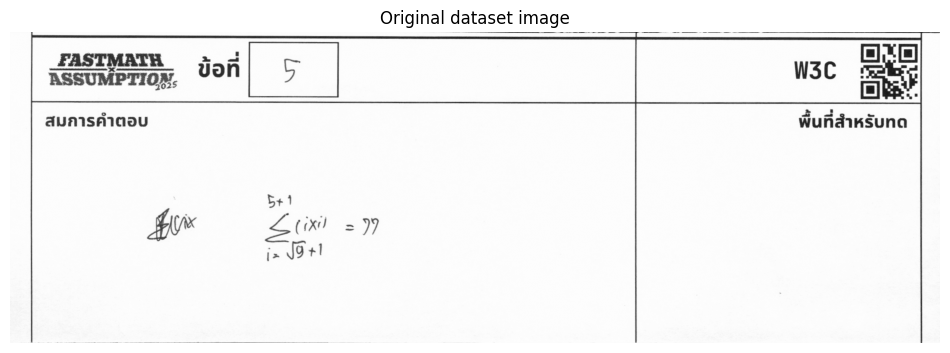

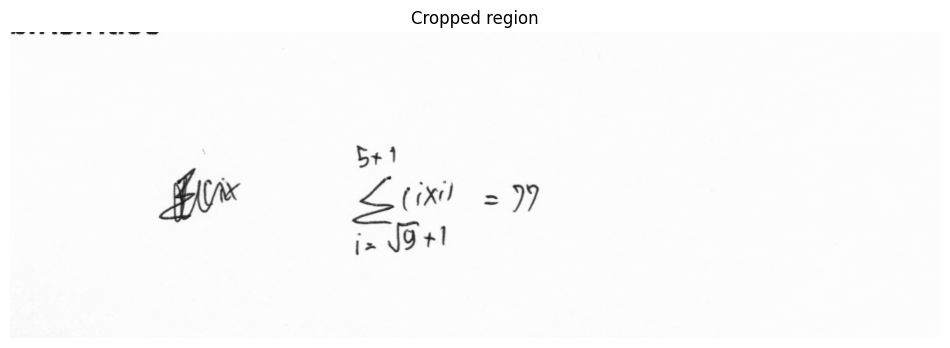

In [6]:
# ============================================================
# CB4.5 — Cropping Test
# ============================================================
import matplotlib.pyplot as plt
from PIL import Image
import random

row = df.sample(1).iloc[0]
img_path = row["filename"]

img = Image.open(img_path).convert("L")
w, h = img.size
print("Image size:", w, "x", h)

plt.figure(figsize=(12, 6))
plt.imshow(img, cmap="gray")
plt.title("Original dataset image")
plt.axis("off")
plt.show()

LEFT_FRAC   = 0.05
RIGHT_FRAC  = 0.66
TOP_FRAC    = 0.30
BOTTOM_FRAC = 0.90

left   = int(LEFT_FRAC * w)
right  = int(RIGHT_FRAC * w)
top    = int(TOP_FRAC * h)
bottom = int(BOTTOM_FRAC * h)

cropped = img.crop((left, top, right, bottom))

plt.figure(figsize=(12, 6))
plt.imshow(cropped, cmap="gray")
plt.title("Cropped region")
plt.axis("off")
plt.show()


In [7]:
# ============================================================
# CB6 — Split Dataset + Build DataLoaders
# ============================================================
from torch.utils.data import random_split, DataLoader

# ✅ Verify images actually exist
existing_mask = df["filename"].apply(os.path.exists)
existing = int(existing_mask.sum())
missing = len(df) - existing
print(f"✅ Found {existing} existing images, 🚨 {missing} missing images.")

df = df[existing_mask].reset_index(drop=True)
print(f"📂 Using {len(df)} valid samples after cleanup.")

# ✅ Split into 90% train, 10% validation
train_size = int(0.9 * len(df))
val_size = len(df) - train_size
train_df, val_df = random_split(df, [train_size, val_size])

# ✅ Create dataset objects
train_ds = HandwritingDataset(train_df.dataset.iloc[train_df.indices], image_root)
val_ds   = HandwritingDataset(val_df.dataset.iloc[val_df.indices], image_root)

# ✅ Create dataloaders
train_dl = DataLoader(train_ds, batch_size=16, shuffle=True, num_workers=4, pin_memory=True)
val_dl   = DataLoader(val_ds, batch_size=16, shuffle=False, num_workers=4, pin_memory=True)

print(f"✅ Training samples: {len(train_ds)}, Validation samples: {len(val_ds)}")


✅ Found 7212 existing images, 🚨 0 missing images.
📂 Using 7212 valid samples after cleanup.
✅ Training samples: 6490, Validation samples: 722


In [10]:
# ============================================================
# CB7 — Im2LatexMini model (encoder attention + deeper decoder)
#            ✅ FIXED FOR GRAYSCALE INPUT
# ============================================================
import torch
import torch.nn as nn
from torchvision import models

class Im2LatexMini(nn.Module):
    def __init__(self, vocab_size, pad_id, d=256, max_len=64, num_dec_layers=6):
        super().__init__()

        # ---- ResNet backbone up to layer4 ----
        resnet = models.resnet18(weights=None)

        # 🔧 IMPORTANT FIX: make first conv accept 1-channel input
        resnet.conv1 = nn.Conv2d(
            in_channels=1,  # <--- was 3
            out_channels=64,
            kernel_size=7,
            stride=2,
            padding=3,
            bias=False,
        )

        self.cnn_backbone = nn.Sequential(
            resnet.conv1, resnet.bn1, resnet.relu, resnet.maxpool,
            resnet.layer1, resnet.layer2, resnet.layer3, resnet.layer4
        )

        # ---- Attention over spatial features (image encoder attention) ----
        self.spatial_attn = nn.MultiheadAttention(
            embed_dim=512, num_heads=8, batch_first=True
        )

        # Project encoder features to Transformer dim
        self.enc_proj = nn.Linear(512, d)

        # ---- Transformer decoder ----
        self.embedding = nn.Embedding(vocab_size, d, padding_idx=pad_id)
        self.pos = nn.Parameter(torch.randn(max_len, d))

        dec_layer = nn.TransformerDecoderLayer(
            d_model=d,
            nhead=8,
            dim_feedforward=512,
            batch_first=True,
        )
        self.decoder = nn.TransformerDecoder(dec_layer, num_layers=num_dec_layers)

        self.out = nn.Linear(d, vocab_size)

        self.max_len = max_len
        self.pad_id = pad_id

    def _generate_causal_mask(self, L, device):
        # True above diagonal → masked positions
        mask = torch.triu(torch.ones(L, L, device=device), diagonal=1).bool()
        return mask

    def forward(self, img, tgt):
        B = img.size(0)

        # ---- CNN encoder ----
        feat_map = self.cnn_backbone(img)   # [B, 512, H, W]
        B, C, H, W = feat_map.shape
        seq = feat_map.view(B, C, H * W).permute(0, 2, 1)  # [B, HW, 512]

        # ---- Spatial self-attention over CNN features ----
        attn_out, _ = self.spatial_attn(seq, seq, seq)     # [B, HW, 512]
        pooled = attn_out.mean(dim=1)                      # [B, 512]

        enc = self.enc_proj(pooled).unsqueeze(1)           # [B, 1, d]

        # ---- Decoder input ----
        tgt_emb = self.embedding(tgt) + self.pos[:tgt.size(1)]   # [B, L, d]

        tgt_mask = self._generate_causal_mask(tgt.size(1), tgt.device)

        dec = self.decoder(tgt=tgt_emb, memory=enc, tgt_mask=tgt_mask)  # [B, L, d]
        logits = self.out(dec)                                          # [B, L, vocab]
        return logits

print("✅ Im2LatexMini defined with grayscale support, encoder attention, and deeper decoder.")



✅ Im2LatexMini defined with grayscale support, encoder attention, and deeper decoder.


In [11]:
# ============================================================
# CB8 — Train the Model (Google Drive Checkpoint Version)
# ============================================================
from google.colab import drive
import os, torch
import numpy as np

drive.mount("/content/drive")

save_dir = "/content/drive/MyDrive/LaTech_checkpoints"
os.makedirs(save_dir, exist_ok=True)
print("📂 Checkpoints will be saved to:", save_dir)

device = "cuda" if torch.cuda.is_available() else "cpu"
print("🚀 Training on:", device)

PAD_ID = tokenizer.pad_token_id
vocab_size = len(tokenizer)
print("Using vocab_size:", vocab_size, "PAD_ID:", PAD_ID)

model = Im2LatexMini(vocab_size=vocab_size, pad_id=PAD_ID, max_len=MAX_LEN).to(device)

criterion = torch.nn.CrossEntropyLoss(ignore_index=PAD_ID)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)

EPOCHS = 30  # realistic for now; you can bump later

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0.0

    for imgs, labels in tqdm(train_dl, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()

        # teacher forcing: feed tokens except last, predict next
        logits = model(imgs, labels[:, :-1])            # [B, L-1, vocab]
        loss = criterion(
            logits.reshape(-1, vocab_size),
            labels[:, 1:].reshape(-1)
        )

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_dl)
    print(f"📉 Epoch {epoch+1}/{EPOCHS} - Training Loss: {avg_loss:.4f}")

    ckpt_path = f"{save_dir}/latech_model_epoch{epoch+1}.pth"
    torch.save(model.state_dict(), ckpt_path)
    print(f"💾 Saved checkpoint: {ckpt_path}")

# final model
final_model_path = f"{save_dir}/latech_model_final.pth"
torch.save(model.state_dict(), final_model_path)
print(f"✅ Final model saved to: {final_model_path}")

# save tokenizer to same folder
tokenizer.save_pretrained(save_dir)
print("✅ Tokenizer saved to Google Drive.")

print("✅ Training complete.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
📂 Checkpoints will be saved to: /content/drive/MyDrive/LaTech_checkpoints
🚀 Training on: cuda
Using vocab_size: 50258 PAD_ID: 50257


Epoch 1/30: 100%|██████████| 406/406 [01:50<00:00,  3.67it/s]


📉 Epoch 1/30 - Training Loss: 2.0728
💾 Saved checkpoint: /content/drive/MyDrive/LaTech_checkpoints/latech_model_epoch1.pth


Epoch 2/30: 100%|██████████| 406/406 [01:34<00:00,  4.28it/s]


📉 Epoch 2/30 - Training Loss: 1.0472
💾 Saved checkpoint: /content/drive/MyDrive/LaTech_checkpoints/latech_model_epoch2.pth


Epoch 3/30: 100%|██████████| 406/406 [01:34<00:00,  4.28it/s]


📉 Epoch 3/30 - Training Loss: 0.8995
💾 Saved checkpoint: /content/drive/MyDrive/LaTech_checkpoints/latech_model_epoch3.pth


Epoch 4/30: 100%|██████████| 406/406 [01:35<00:00,  4.27it/s]


📉 Epoch 4/30 - Training Loss: 0.8081
💾 Saved checkpoint: /content/drive/MyDrive/LaTech_checkpoints/latech_model_epoch4.pth


Epoch 5/30: 100%|██████████| 406/406 [01:34<00:00,  4.27it/s]


📉 Epoch 5/30 - Training Loss: 0.7380
💾 Saved checkpoint: /content/drive/MyDrive/LaTech_checkpoints/latech_model_epoch5.pth


Epoch 6/30: 100%|██████████| 406/406 [01:34<00:00,  4.28it/s]


📉 Epoch 6/30 - Training Loss: 0.6847
💾 Saved checkpoint: /content/drive/MyDrive/LaTech_checkpoints/latech_model_epoch6.pth


Epoch 7/30: 100%|██████████| 406/406 [01:34<00:00,  4.28it/s]


📉 Epoch 7/30 - Training Loss: 0.6338
💾 Saved checkpoint: /content/drive/MyDrive/LaTech_checkpoints/latech_model_epoch7.pth


Epoch 8/30: 100%|██████████| 406/406 [01:35<00:00,  4.27it/s]


📉 Epoch 8/30 - Training Loss: 0.5904
💾 Saved checkpoint: /content/drive/MyDrive/LaTech_checkpoints/latech_model_epoch8.pth


Epoch 9/30: 100%|██████████| 406/406 [01:34<00:00,  4.28it/s]


📉 Epoch 9/30 - Training Loss: 0.5475
💾 Saved checkpoint: /content/drive/MyDrive/LaTech_checkpoints/latech_model_epoch9.pth


Epoch 10/30: 100%|██████████| 406/406 [01:34<00:00,  4.28it/s]


📉 Epoch 10/30 - Training Loss: 0.5040
💾 Saved checkpoint: /content/drive/MyDrive/LaTech_checkpoints/latech_model_epoch10.pth


Epoch 11/30: 100%|██████████| 406/406 [01:34<00:00,  4.28it/s]


📉 Epoch 11/30 - Training Loss: 0.4670
💾 Saved checkpoint: /content/drive/MyDrive/LaTech_checkpoints/latech_model_epoch11.pth


Epoch 12/30: 100%|██████████| 406/406 [01:34<00:00,  4.28it/s]


📉 Epoch 12/30 - Training Loss: 0.4316
💾 Saved checkpoint: /content/drive/MyDrive/LaTech_checkpoints/latech_model_epoch12.pth


Epoch 13/30: 100%|██████████| 406/406 [01:35<00:00,  4.27it/s]


📉 Epoch 13/30 - Training Loss: 0.4043
💾 Saved checkpoint: /content/drive/MyDrive/LaTech_checkpoints/latech_model_epoch13.pth


Epoch 14/30: 100%|██████████| 406/406 [01:34<00:00,  4.27it/s]


📉 Epoch 14/30 - Training Loss: 0.3774
💾 Saved checkpoint: /content/drive/MyDrive/LaTech_checkpoints/latech_model_epoch14.pth


Epoch 15/30: 100%|██████████| 406/406 [01:34<00:00,  4.29it/s]


📉 Epoch 15/30 - Training Loss: 0.3524
💾 Saved checkpoint: /content/drive/MyDrive/LaTech_checkpoints/latech_model_epoch15.pth


Epoch 16/30: 100%|██████████| 406/406 [01:34<00:00,  4.28it/s]


📉 Epoch 16/30 - Training Loss: 0.3338
💾 Saved checkpoint: /content/drive/MyDrive/LaTech_checkpoints/latech_model_epoch16.pth


Epoch 17/30: 100%|██████████| 406/406 [01:35<00:00,  4.27it/s]


📉 Epoch 17/30 - Training Loss: 0.3121
💾 Saved checkpoint: /content/drive/MyDrive/LaTech_checkpoints/latech_model_epoch17.pth


Epoch 18/30: 100%|██████████| 406/406 [01:34<00:00,  4.29it/s]


📉 Epoch 18/30 - Training Loss: 0.2989
💾 Saved checkpoint: /content/drive/MyDrive/LaTech_checkpoints/latech_model_epoch18.pth


Epoch 19/30: 100%|██████████| 406/406 [01:34<00:00,  4.30it/s]


📉 Epoch 19/30 - Training Loss: 0.2799
💾 Saved checkpoint: /content/drive/MyDrive/LaTech_checkpoints/latech_model_epoch19.pth


Epoch 20/30: 100%|██████████| 406/406 [01:34<00:00,  4.29it/s]


📉 Epoch 20/30 - Training Loss: 0.2683
💾 Saved checkpoint: /content/drive/MyDrive/LaTech_checkpoints/latech_model_epoch20.pth


Epoch 21/30: 100%|██████████| 406/406 [01:34<00:00,  4.28it/s]


📉 Epoch 21/30 - Training Loss: 0.2532
💾 Saved checkpoint: /content/drive/MyDrive/LaTech_checkpoints/latech_model_epoch21.pth


Epoch 22/30: 100%|██████████| 406/406 [01:35<00:00,  4.26it/s]


📉 Epoch 22/30 - Training Loss: 0.2390
💾 Saved checkpoint: /content/drive/MyDrive/LaTech_checkpoints/latech_model_epoch22.pth


Epoch 23/30: 100%|██████████| 406/406 [01:34<00:00,  4.28it/s]


📉 Epoch 23/30 - Training Loss: 0.2302
💾 Saved checkpoint: /content/drive/MyDrive/LaTech_checkpoints/latech_model_epoch23.pth


Epoch 24/30: 100%|██████████| 406/406 [01:34<00:00,  4.30it/s]


📉 Epoch 24/30 - Training Loss: 0.2117
💾 Saved checkpoint: /content/drive/MyDrive/LaTech_checkpoints/latech_model_epoch24.pth


Epoch 25/30: 100%|██████████| 406/406 [01:34<00:00,  4.29it/s]


📉 Epoch 25/30 - Training Loss: 0.2054
💾 Saved checkpoint: /content/drive/MyDrive/LaTech_checkpoints/latech_model_epoch25.pth


Epoch 26/30: 100%|██████████| 406/406 [01:34<00:00,  4.29it/s]


📉 Epoch 26/30 - Training Loss: 0.1931
💾 Saved checkpoint: /content/drive/MyDrive/LaTech_checkpoints/latech_model_epoch26.pth


Epoch 27/30: 100%|██████████| 406/406 [01:34<00:00,  4.30it/s]


📉 Epoch 27/30 - Training Loss: 0.1845
💾 Saved checkpoint: /content/drive/MyDrive/LaTech_checkpoints/latech_model_epoch27.pth


Epoch 28/30: 100%|██████████| 406/406 [01:34<00:00,  4.29it/s]


📉 Epoch 28/30 - Training Loss: 0.1743
💾 Saved checkpoint: /content/drive/MyDrive/LaTech_checkpoints/latech_model_epoch28.pth


Epoch 29/30: 100%|██████████| 406/406 [01:34<00:00,  4.28it/s]


📉 Epoch 29/30 - Training Loss: 0.1646
💾 Saved checkpoint: /content/drive/MyDrive/LaTech_checkpoints/latech_model_epoch29.pth


Epoch 30/30: 100%|██████████| 406/406 [01:35<00:00,  4.27it/s]


📉 Epoch 30/30 - Training Loss: 0.1564
💾 Saved checkpoint: /content/drive/MyDrive/LaTech_checkpoints/latech_model_epoch30.pth
✅ Final model saved to: /content/drive/MyDrive/LaTech_checkpoints/latech_model_final.pth
✅ Tokenizer saved to Google Drive.
✅ Training complete.


In [12]:
#CB8.25 - File Checking Stage
import os

for f in ["latech_model.pth", "itos.npy", "stoi.npy"]:
    path = os.path.join("/content", f)
    print(f"{'✅ Found' if os.path.exists(path) else '❌ Missing'}: {path}")

❌ Missing: /content/latech_model.pth
❌ Missing: /content/itos.npy
❌ Missing: /content/stoi.npy


In [13]:
# ============================================================
# CB8.5 — Reload latest model + tokenizer from Google Drive
# ============================================================
import os, torch
from transformers import AutoTokenizer

device = "cuda" if torch.cuda.is_available() else "cpu"
print("🖥 Using device:", device)

save_dir = "/content/drive/MyDrive/LaTech_checkpoints"
if not os.path.exists(save_dir):
    raise FileNotFoundError(f"❌ Checkpoint directory not found: {save_dir}")

print("📥 Loading tokenizer from Google Drive...")
tokenizer = AutoTokenizer.from_pretrained(save_dir)
PAD_ID = tokenizer.pad_token_id
BOS_ID = tokenizer.bos_token_id
EOS_ID = tokenizer.eos_token_id
MAX_LEN = 64  # must match training
vocab_size = len(tokenizer)

print(f"✅ Tokenizer loaded (vocab_size={vocab_size}, PAD={PAD_ID}, BOS={BOS_ID}, EOS={EOS_ID})")

final_ckpt = os.path.join(save_dir, "latech_model_final.pth")
if os.path.exists(final_ckpt):
    ckpt_path = final_ckpt
else:
    ckpts = sorted([f for f in os.listdir(save_dir) if f.endswith(".pth") and "epoch" in f])
    if not ckpts:
        raise FileNotFoundError("❌ No .pth checkpoints found in checkpoint folder.")
    ckpt_path = os.path.join(save_dir, ckpts[-1])

print(f"✅ Loading checkpoint: {os.path.basename(ckpt_path)}")

model = Im2LatexMini(vocab_size=vocab_size, pad_id=PAD_ID, max_len=MAX_LEN).to(device)
state_dict = torch.load(ckpt_path, map_location=device)
model.load_state_dict(state_dict)
model.eval()

print("✅ Model & tokenizer loaded and ready for inference.")


🖥 Using device: cuda
📥 Loading tokenizer from Google Drive...
✅ Tokenizer loaded (vocab_size=50258, PAD=50257, BOS=50256, EOS=50256)
✅ Loading checkpoint: latech_model_final.pth
✅ Model & tokenizer loaded and ready for inference.


PAD_ID=50257, BOS_ID=50256, EOS_ID=50256


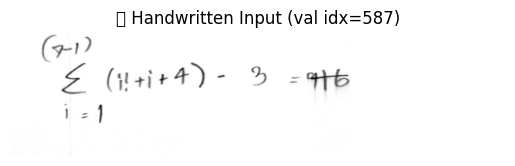

🧮 Predicted LaTeX: \sum_{i={0!}}^7\left(i+i\right)-\left(\frac{8}{2}\right)=52
✅ True LaTeX:      \sum_{i={1}}^{\left(7-1\right)}\left(i!+i+4\right)-3=916


<IPython.core.display.Math object>

In [20]:
# ============================================================
# CB9 — Evaluate + Visualize Model Predictions (BPE version)
# ============================================================
import random
from IPython.display import display, Math
import matplotlib.pyplot as plt
import torch

model.eval()

PAD_ID = tokenizer.pad_token_id
BOS_ID = tokenizer.bos_token_id
EOS_ID = tokenizer.eos_token_id

print(f"PAD_ID={PAD_ID}, BOS_ID={BOS_ID}, EOS_ID={EOS_ID}")

# pick a random validation sample
idx = random.randint(0, len(val_ds) - 1)
img, label_ids = val_ds[idx]

plt.imshow(img.squeeze(), cmap="gray")
plt.axis("off")
plt.title(f"📝 Handwritten Input (val idx={idx})")
plt.show()

img = img.unsqueeze(0).to(device)

max_len = MAX_LEN
generated_ids = [BOS_ID]

for _ in range(max_len):
    tgt = torch.tensor([generated_ids], dtype=torch.long, device=device)  # [1, L]
    with torch.no_grad():
        logits = model(img, tgt)       # [1, L, vocab]
    next_id = logits[0, -1].argmax().item()

    if next_id in (EOS_ID, PAD_ID):
        break
    generated_ids.append(next_id)

# strip BOS/EOS/PAD for decoding
pred_ids_for_decode = [tid for tid in generated_ids if tid not in (BOS_ID, EOS_ID, PAD_ID)]
true_ids_for_decode = [int(t) for t in label_ids.tolist() if t not in (BOS_ID, EOS_ID, PAD_ID)]

pred_str = tokenizer.decode(pred_ids_for_decode, skip_special_tokens=True)
true_str = tokenizer.decode(true_ids_for_decode, skip_special_tokens=True)

print("🧮 Predicted LaTeX:", pred_str)
print("✅ True LaTeX:     ", true_str)

try:
    display(Math(pred_str))
except Exception as e:
    print("⚠️ Could not render predicted LaTeX as Math:", e)
